In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from Data import AlphaVantageAPI
from Data import SQLRepository
from  config import settings
import sqlite3

In [2]:
av = AlphaVantageAPI()

In [3]:
df_ambuja = av.get_data(ticker='AMBUJACEM.BSE')

In [4]:
# Is df a dataframe
assert isinstance(df_ambuja, pd.DataFrame)
# Does df have 5 columns
assert  df_ambuja.shape[1] == 5
# Is `df index` a Datetimeindex
assert  isinstance(df_ambuja.index, pd.DatetimeIndex)
# Check if `df index` name is date
assert df_ambuja.index.name == 'date'

In [5]:
connection = sqlite3.connect(settings.db_name, check_same_thread = False)

In [6]:
repo = SQLRepository(connection = connection)
# Does `repo` have a "connection" attribute?
assert hasattr(repo, "connection")

# Is the "connection" attribute a SQLite `Connection`?
assert isinstance(repo.connection, sqlite3.Connection)

In [7]:
ticker='AMBUJACEM.BSE'
response = repo.insert_data(table_name=ticker, record= df_ambuja, if_exists="replace")
# Does your method return a dictionary?
assert isinstance(response, dict)

# Are the keys of that dictionary correct?
assert sorted(list(response.keys())) == ["records_inserted", "transaction_successful"]

In [8]:
df = repo.read_data(table_name="AMBUJACEM.BSE", limit=None)
# Is `df` a DataFrame?
assert isinstance(df, pd.DataFrame)

# Does it have a `DatetimeIndex`?
assert isinstance(df.index, pd.DatetimeIndex)

# Is the index named "date"?
assert df.index.name == "date"

# Does it have 2,500 rows and 5 columns?
#assert df.shape == (100, 5)

# Are the column names correct?
assert df.columns.to_list() == ['open', 'high', 'low', 'close', 'volume']

# Are the column data types correct?
assert all(df.dtypes == float)

# Print `` info
print(" shape:",df.shape)
print()
print(df.info())
df

 shape: (100, 5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2023-11-23 to 2023-06-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    100 non-null    float64
 1   high    100 non-null    float64
 2   low     100 non-null    float64
 3   close   100 non-null    float64
 4   volume  100 non-null    float64
dtypes: float64(5)
memory usage: 4.7 KB
None


,open,high,low,close,volume
date,,,,,
2023-11-23,414.40,416.75,408.60,415.50,93005.0
2023-11-22,419.15,420.85,413.15,414.30,38283.0
2023-11-21,421.55,424.20,419.00,420.05,73550.0
2023-11-20,420.90,424.10,418.25,421.50,707595.0
2023-11-17,421.10,427.80,418.90,420.90,92228.0
...,...,...,...,...,...
2023-07-06,431.05,435.55,429.25,431.55,147929.0
2023-07-05,431.35,434.20,426.90,432.45,47152.0
2023-07-04,435.10,438.15,430.85,432.60,234799.0


In [9]:
# Create Daily return column
df["return"] = df['close'].pct_change()*100
df['return'].dropna(inplace=True)
df['return'].ffill(inplace=True)
df.shape

(100, 6)

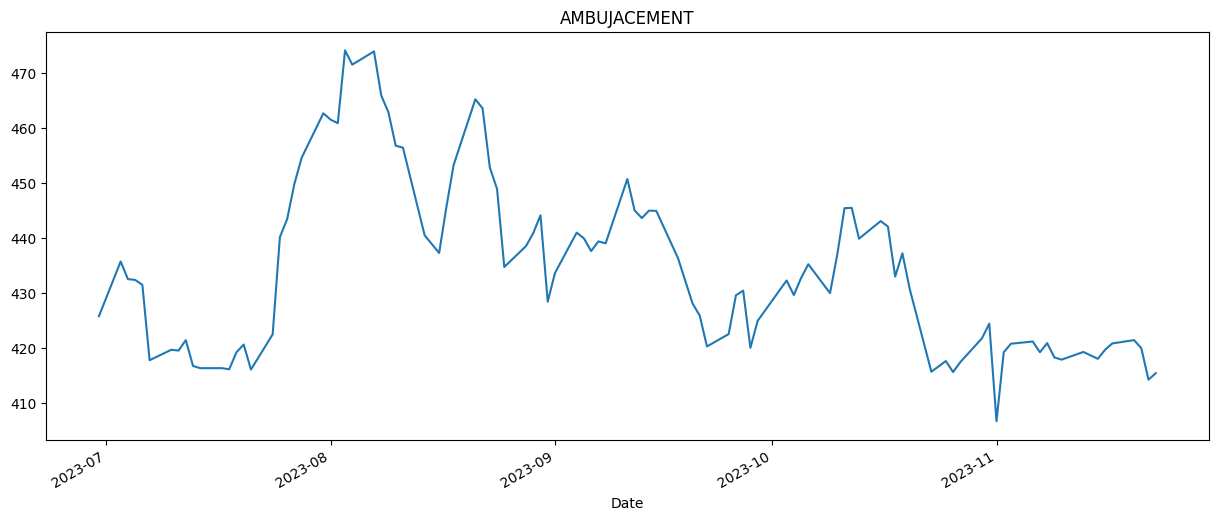

In [10]:
fig, ax = plt.subplots(figsize = (15,6))
df['close'].plot()
plt.xlabel("Date")
plt.title("AMBUJACEMENT");

In [11]:
y_ambuja = df["return"].dropna()
print(y_ambuja.dtypes)
y_ambuja.ffill()

float64


date
2023-11-22   -0.288809
2023-11-21    1.387883
2023-11-20    0.345197
2023-11-17   -0.142349
2023-11-16   -0.273224
                ...   
2023-07-06    3.278689
2023-07-05    0.208551
2023-07-04    0.034686
2023-07-03    0.739713
2023-06-30   -2.283157
Name: return, Length: 99, dtype: float64

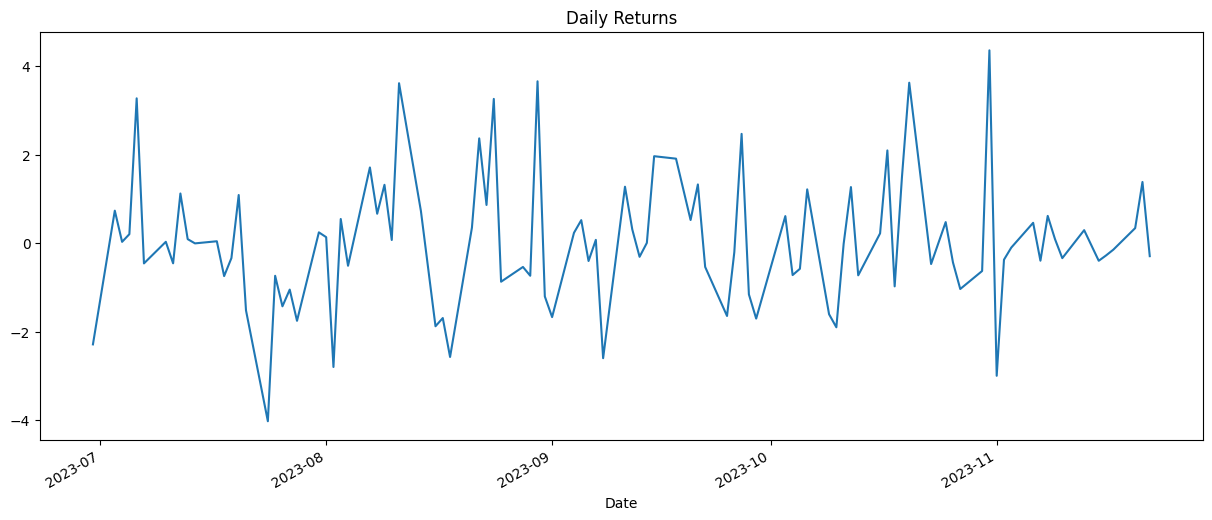

In [12]:
fig, ax = plt.subplots(figsize = (15,6))
df["return"].plot(ax=ax)
plt.xlabel("Date")
plt.title("Daily Returns");

In [13]:
ambuja_daily_volatility = y_ambuja.std()
print("Ambuja Daily Volatility:", ambuja_daily_volatility)

Ambuja Daily Volatility: 1.495613423904634


In [14]:
ambuja_annual_volatility = ambuja_daily_volatility * np.sqrt(252)

print("Suzlon Annual Volatility:", ambuja_annual_volatility)

Suzlon Annual Volatility: 23.74212706284892


In [15]:
ambuja_rolling_50d_volatility = y_ambuja.rolling(window = 50).std().dropna()

print("rolling_50d_volatility type:", type(ambuja_rolling_50d_volatility))
print("rolling_50d_volatility shape:", ambuja_rolling_50d_volatility.shape)
ambuja_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (50,)


date
2023-09-08    1.401567
2023-09-07    1.400341
2023-09-06    1.390278
2023-09-05    1.391182
2023-09-04    1.390897
Name: return, dtype: float64

Text(0.5, 0, 'Date')

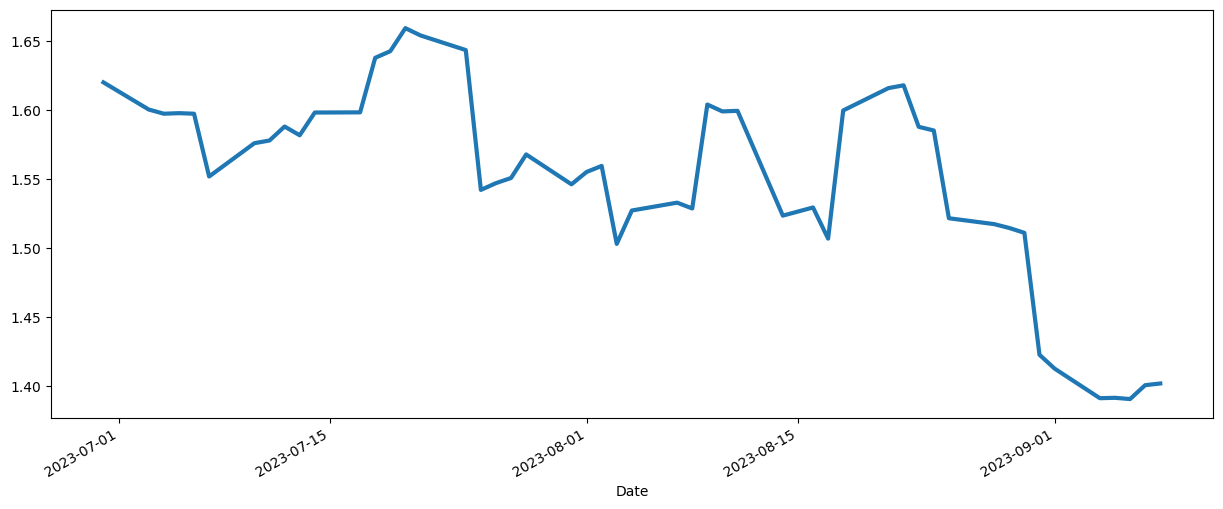

In [16]:
# Plot `ambuja_rolling_50d_volatility`
fig, ax = plt.subplots(figsize = (15,6))
y_ambuja.rolling(window = 50).std().dropna().plot(ax = ax, label = "50d rolling volatility", linewidth = 3)

# Add x-axis label
plt.xlabel("Date")

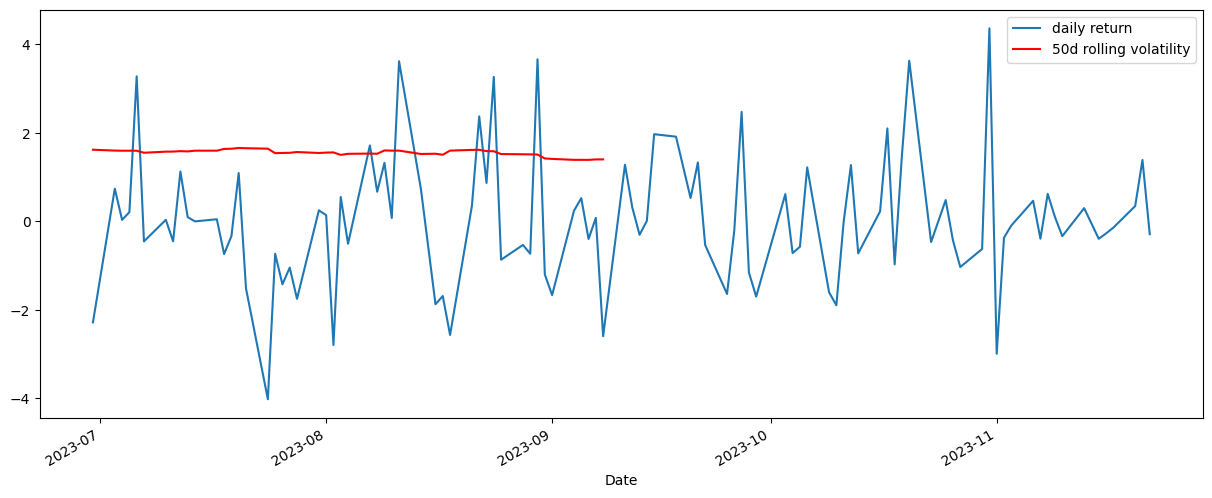

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja`
y_ambuja.plot(ax = ax, label = "daily return")

# Plot `ambuja_rolling_50d_volatility`
ambuja_rolling_50d_volatility.plot(ax = ax, label = "50d rolling volatility",color='red')

# Add x-axis label
plt.xlabel("Date")

# Add legend
plt.legend();

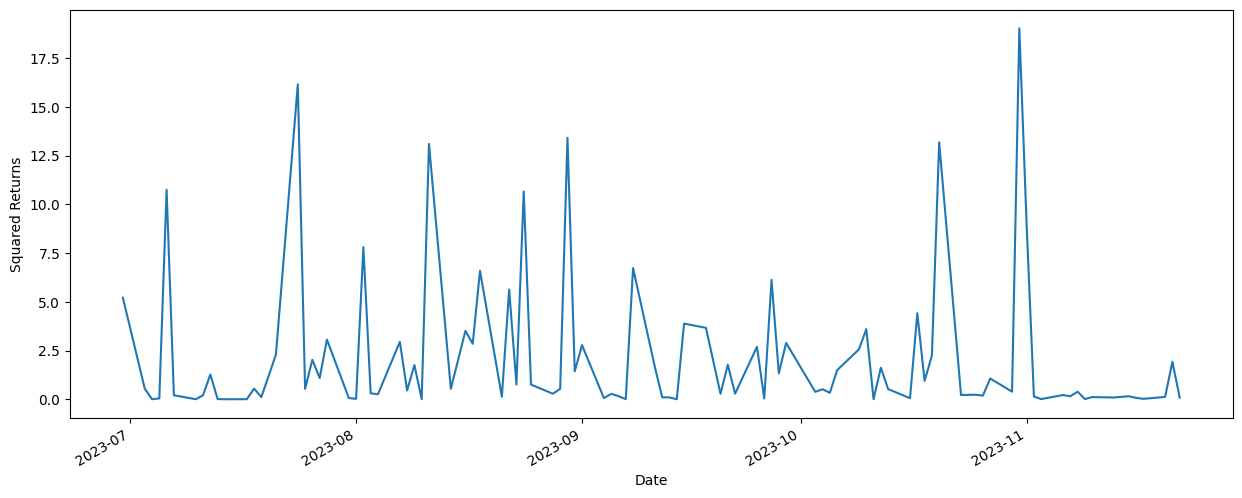

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y_ambuja ** 2).plot(ax = ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared Returns");

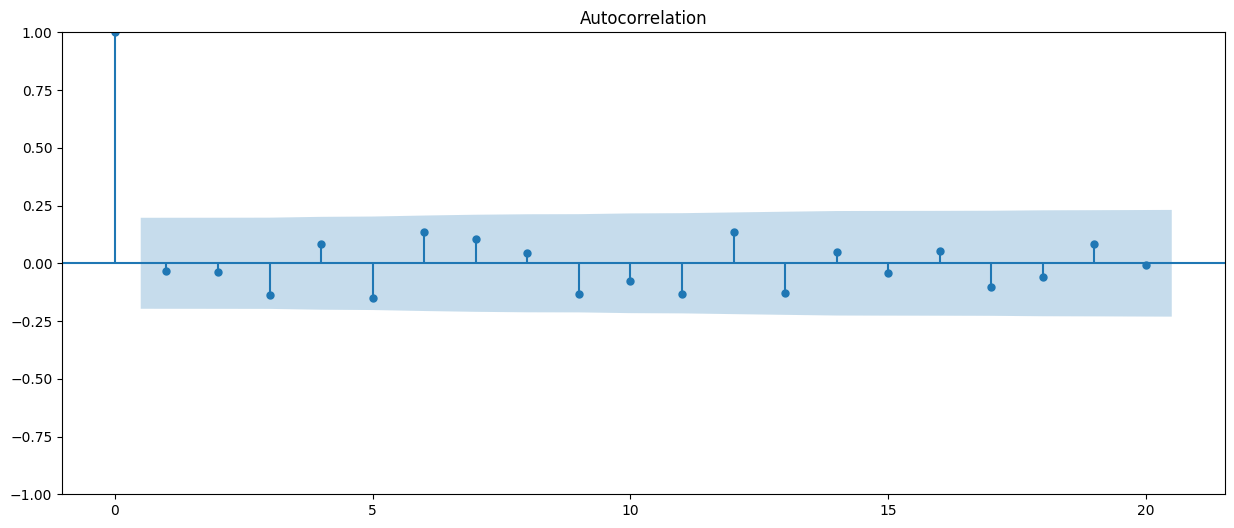

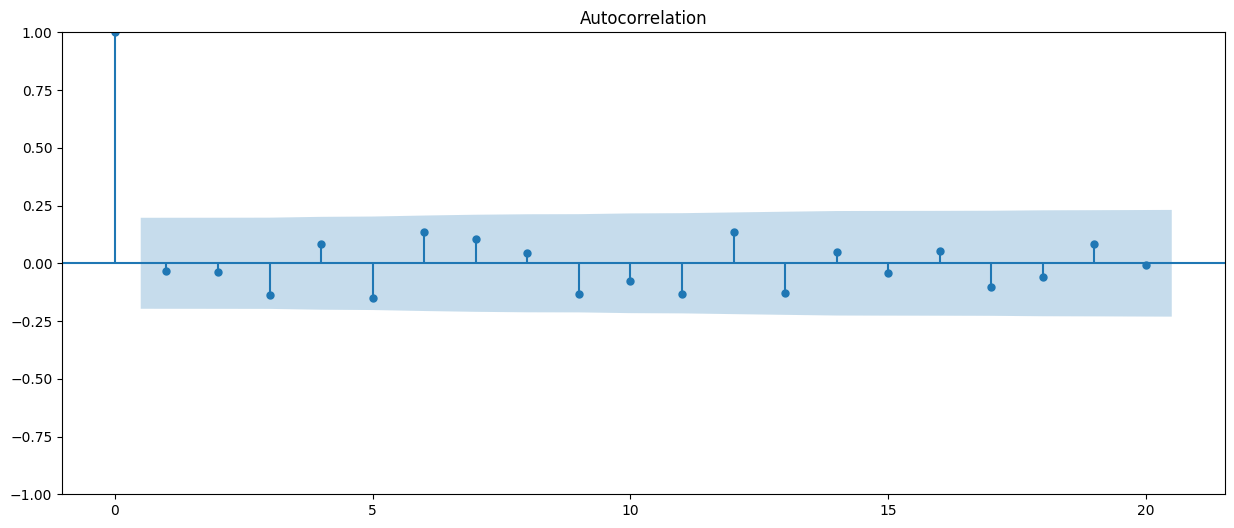

In [19]:
fig, ax = plt.subplots(figsize = (15,6))
plot_acf(y_ambuja**2, ax=ax)

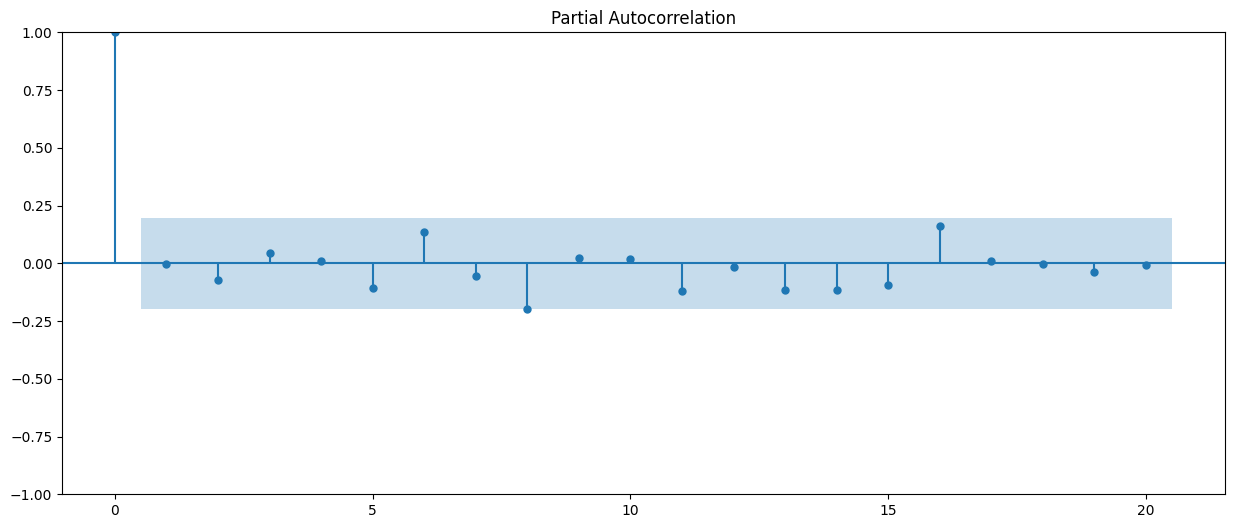

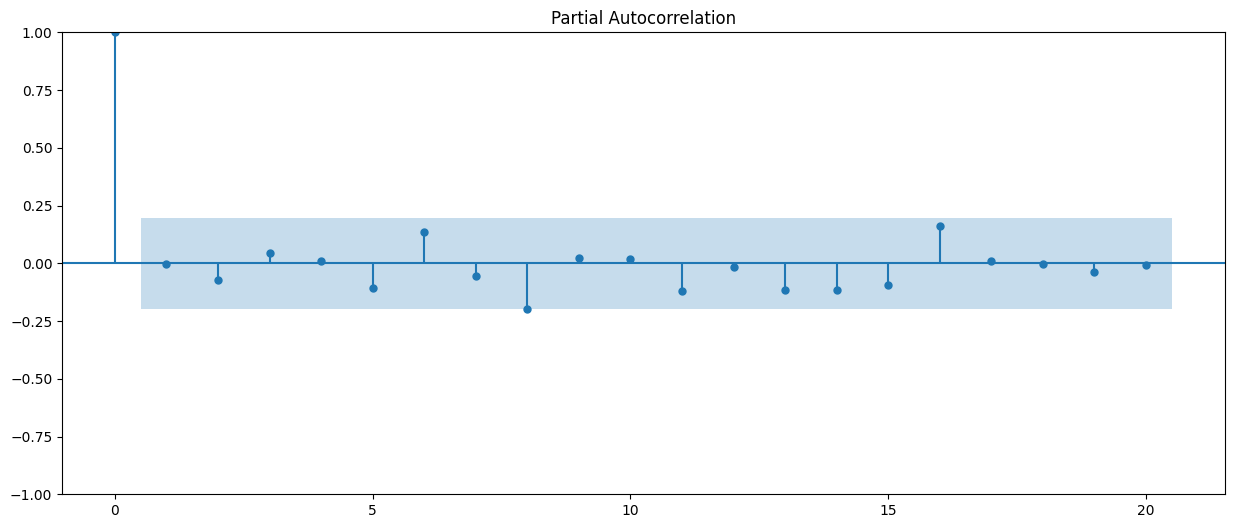

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y_ambuja, ax=ax)

In [21]:
cutoff = int(len(y_ambuja)*0.8)
y_ambuja_train = y_ambuja.iloc[:cutoff]

In [22]:
model = arch_model(y_ambuja_train, p=1, q=1, rescale=False).fit(disp=0)

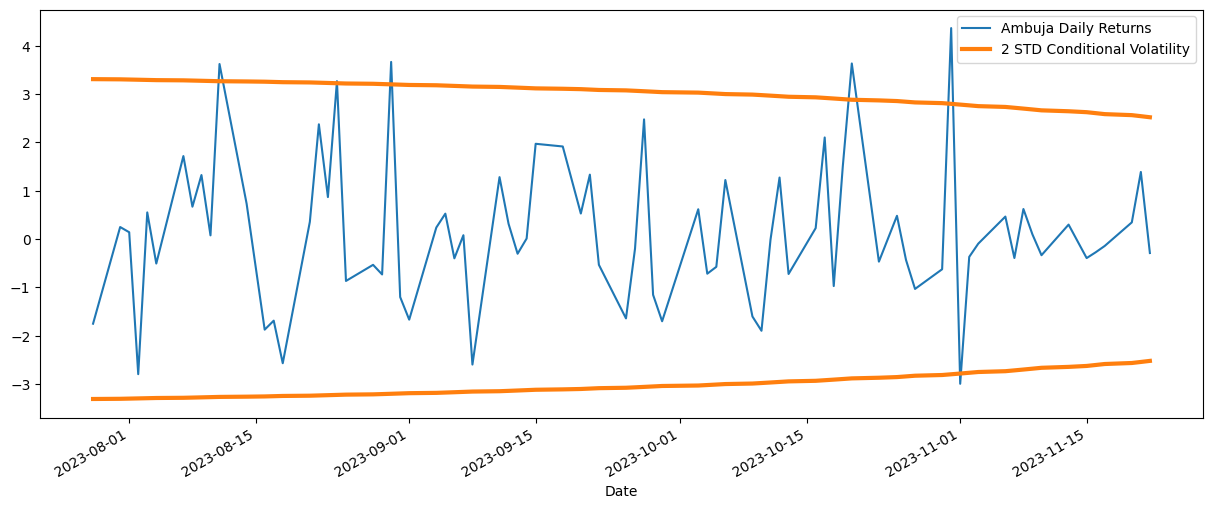

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
y_ambuja_train.plot(ax = ax, label = "Ambuja Daily Returns")

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
   ax = ax, color = "C1", label = "2 STD Conditional Volatility", linewidth = 3 
)

# Plot conditional volatility * -2
(-2 * model.conditional_volatility.rename("")).plot(
   ax = ax, color = "C1", linewidth = 3 
)

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

In [24]:
model.std_resid

date
2023-11-22   -0.329226
2023-11-21    0.992969
2023-11-20    0.171067
2023-11-17   -0.207659
2023-11-16   -0.306538
                ...   
2023-08-03    0.258460
2023-08-02   -1.772118
2023-08-01    0.009125
2023-07-31    0.074568
2023-07-28   -1.134559
Name: std_resid, Length: 79, dtype: float64

In [25]:
one_day_forecast = model.forecast(horizon = 1, reindex = False).variance # the Prediction is a variance which is std sqr

# prediction is for the next day value
print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2023-07-28,2.741494


In [26]:
test_size = int(len(y_ambuja)*0.2)
predictions= []

for i in range(test_size):
   y_train = y_ambuja.iloc[:-(test_size - i)]
   model = arch_model(y_train, 
              p=1,
              q=1,
              rescale=False
              ).fit(disp=0)
   # Generate next prediction (volatility, not variance)
   next_pred = model.forecast(horizon = 1, reindex = False).variance.iloc[0,0] ** 0.5
   predictions.append(next_pred)
# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y_ambuja.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv
   

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (19,)


date
2023-07-26    1.632905
2023-07-25    1.627937
2023-07-24    1.600248
2023-07-21    1.813937
2023-07-20    1.811734
2023-07-19    1.803233
2023-07-18    1.751974
2023-07-17    1.705410
2023-07-14    1.659973
2023-07-13    1.624575
2023-07-12    1.596646
2023-07-11    1.585470
2023-07-10    1.566134
2023-07-07    1.548322
2023-07-06    1.533963
2023-07-05    1.596989
2023-07-04    1.575927
2023-07-03    1.557875
2023-06-30    1.545368
dtype: float64

In [29]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

# Calculate forecast start date
start = prediction.index[0] + pd.DateOffset(days = 1)

# Create date range
prediction_dates = pd.bdate_range(start = start, periods = prediction.shape[1])

# Create prediction index labels, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
prediction_index[:3]

                 h.1      h.2       h.3       h.4       h.5
date                                                       
2023-07-03  1.545368  1.54544  1.545508  1.545573  1.545634
prediction_index type: <class 'list'>
prediction_index len: 5


['2023-07-04T00:00:00', '2023-07-05T00:00:00', '2023-07-06T00:00:00']